# Simple audio recognition: Recognizing keywords

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [14]:
import utils
from utils.audio_utils import *
from utils.audio_models import *
from utils.keras_utils import *

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


## Speech dataset (2.11 GB uncompressed)
#### http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

In [15]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

# Speech dataset (2.11 GB uncompressed)
# http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

# if not data_dir.exists():
#     tf.keras.utils.get_file(
#     'mini_speech_commands.zip',
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
#     extract=True,
#     cache_dir='.', cache_subdir='data')

## File signal example and feature vector calculation

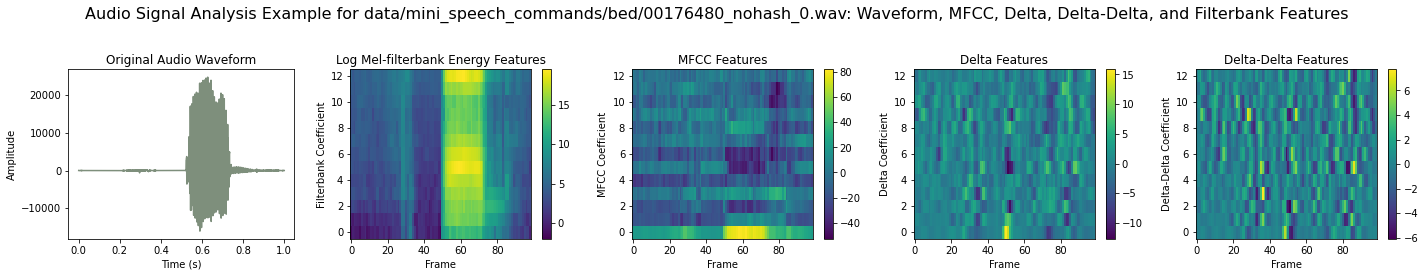

In [16]:
# Load an example audio file for inference
data_dir = 'data/mini_speech_commands/bed/'
file = '00176480_nohash_0.wav'
file_path = os.path.join(data_dir, file)
rate, example_signal = wavfile.read(file_path)

sig_ds, rate_ds, feature_dicts = example_feature_vectors(file_path, 1)

# Separate dictionaries for each feature type
signal_dict = feature_dicts['signal_dict']
mfcc_dict = feature_dicts['mfcc_dict']
delta_dict = feature_dicts['delta_dict']
delta_delta_dict = feature_dicts['delta_delta_dict']
fbank_dict = feature_dicts['fbank_dict']
full_feature_vector_dict = feature_dicts['full_feature_vector_dict']

plot_example(sig_ds, rate_ds, fbank_dict,mfcc_dict, delta_dict, delta_delta_dict, file_path)

## Calculate the feature vectors of words

In [17]:
# Load the feature vectors from the saved pickle file
load_path = 'feature_data/ten_words.pkl'
with open(load_path, 'rb') as file:
    signal_ds, spectro_ds, mfcc_ds, delta_ds, delta_delta_ds, full_feature_vector_ds = pickle.load(file)


In [18]:
# Convert each dictionary value from list to array
convert_to_arrays(signal_ds)
convert_to_arrays(spectro_ds)
convert_to_arrays(mfcc_ds)
convert_to_arrays(delta_ds)
convert_to_arrays(delta_delta_ds)
convert_to_arrays(full_feature_vector_ds)

# Add channel axis, N, 99, 13, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(signal_ds)
add_new_axis(spectro_ds)
add_new_axis(mfcc_ds)
add_new_axis(delta_ds)
add_new_axis(delta_delta_ds)
# Add channel axis, N, 99, 43, 1. Where 1 is the channel of spectrogram intensity
add_new_axis(full_feature_vector_ds)

# Investigate recent/new ANN architectures

## Autoencoder-based (CNN/RNN autoencoder + following SVM)

In [19]:
def preprocess_dataset_autoencoder(dataset, test_size=0.2, random_state=42):
    """
    Preprocesses the given dataset.

    Args:
    - dataset (dict): A dictionary with labels as keys and corresponding spectrograms as values.
    - test_size (float): The proportion of the dataset to include in the test split (default is 0.2).
    - random_state (int): Seed used by the random number generator (default is 42).

    Returns:
    - X_train, X_test, Y_train, Y_test, Array_train, Array_test: Processed training and testing data.
    """

    # Obtain the classes labels, or words
    labels = np.array(list(dataset.keys()))
    
    spectrograms = np.array(list(dataset.values()), dtype=object)
    
    # Initialize OneHotEncoder to avoid ordinal relationships
    one_hot_encoder = OneHotEncoder()

    # Reshape y to a 2D array (required by OneHotEncoder)
    y_reshaped = labels.reshape(-1, 1)

    # Fit and transform y to one-hot encoded format
    y_one_hot = one_hot_encoder.fit_transform(y_reshaped)

    # Convert one-hot encoded output to an array
    y_encoded = y_one_hot.toarray()


    X = []
    Arrays = []
    Y = []

    for w, label in enumerate(spectrograms):
        for i, mfcc in enumerate(label):
            X.append(f'{labels[w]}_{i}')
            Arrays.append(mfcc)
            Y.append(y_encoded[w])

    # split the dataset into train and test groups using the package sklearn
    X_train, X_test, Y_train, Y_test, Array_train, Array_test = train_test_split(X, Y, Arrays, test_size=test_size, random_state=random_state)

    Array_train = np.array(Array_train)
    Array_test = np.array(Array_test)
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)

    # Add a channel axis at the end for Array_train
    Array_train = Array_train[..., np.newaxis]

    # Add a channel axis at the end for Array_test
    Array_test = Array_test[..., np.newaxis]

    # Specify the amount of padding for each dimension
    pad_width = ((0, 0), (0, 1), (3, 4), (0, 0))

    # Pad the array with zeros
    Array_train = np.pad(Array_train, pad_width, mode='constant', constant_values=0)
    Array_test = np.pad(Array_test, pad_width, mode='constant', constant_values=0)

    # Decoding one-hot encoded labels for training and testing sets
    decoded_labels_train = one_hot_encoder.inverse_transform(Y_train)
    decoded_labels_test = one_hot_encoder.inverse_transform(Y_test)

    return X_train, X_test, Y_train, Y_test, Array_train, Array_test, y_encoded, one_hot_encoder, decoded_labels_train, decoded_labels_test

In [20]:
X_train, X_test, Y_train, Y_test, Array_train, Array_test, one_hot_labels, one_hot_encoder, Y_decoded_train, Y_decoded_test = preprocess_dataset(mfcc_ds)


## Show some examples

In [21]:
# Perform data augmentation
Array_train_augmented = augment_data(Array_train, augmentation_percentage=0.2)

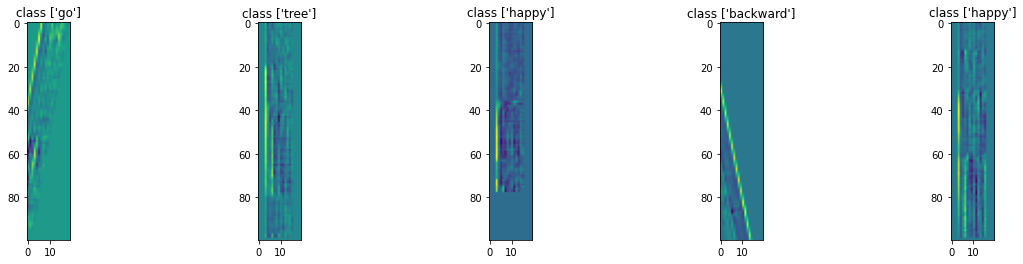

In [22]:
plt.figure(figsize=[20, 4])
plt.subplot(1, 10, 1)

for i in range(5):
    plt.subplot(1, 5, i + 1, label="Subplot {}".format(i + 1))
    image = Array_train_augmented[i, :, :, :]
    plt.imshow(image.tolist())
    label = Y_decoded_train[i]
    plt.title('class ' + str(label))

plt.show()

In [23]:
Array_train_augmented = Array_train_augmented.tolist()
Array_test = Array_test.tolist()

In [24]:
batch_size = 32
train_dataset = create_dataset(X_train,
                               Array_train_augmented,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='feature_data/autoencoder/train_cache_autoencoder')

test_dataset = create_dataset(X_test,
                              Array_test,
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='feature_data/autoencoder/val_cache_autoencoder')

train_steps = int(np.ceil(len(X_train) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

Created dataset from tensor slices
Mapped normalize function
Duplicated data for autoencoder (input=output)
Cached dataset
Shuffled dataset
Repeated dataset
Batched dataset
Prefetched dataset
Created dataset from tensor slices
Mapped normalize function
Duplicated data for autoencoder (input=output)
Cached dataset
Repeated dataset
Batched dataset
Prefetched dataset


## Test IMG SHAPE compatability with AUTOENCODER

In [25]:
IMG_SHAPE = (100,20,1)

# check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1, 8, 32, 128, 512]:
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    print(encoder.output_shape[1:])
    print(decoder.output_shape[1:])
    assert encoder.output_shape[1:] == (code_size,), "encoder must output a code of required size"
    assert decoder.output_shape[1:] == IMG_SHAPE, "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights) >= 6, "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights) >= 6, "decoder must contain at least 3 layers"

    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)" % (
        layer.name, get_dim(layer))

print("All tests passed!")

Testing code size 1
(1,)
(100, 20, 1)
Testing code size 8
(8,)
(100, 20, 1)
Testing code size 32
(32,)
(100, 20, 1)
Testing code size 128
(128,)
(100, 20, 1)
Testing code size 512
(512,)
(100, 20, 1)
All tests passed!


# Train

In [26]:
# # Look at encoder and decoder shapes. The total number of trainable parameters of encoder and decoder should be close
# encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
# encoder.summary()
# decoder.summary()

# # build the deep autoencoder network

# # 1- instatiate the input tensor (hint: use tf.keras.Input(IMG_SHAPE))
# # 2- get the code (output of the encoder)
# # 3 -pass the code to the decoder and get the recunstruction
# ### START CODE HERE ###
# inp = tf.keras.Input(IMG_SHAPE)
# code = encoder(inp)
# reconstruction = decoder(code)
# ### END CODE HERE ###

# # create the autoencoder model: use tf.keras.Model() with the correct input and output tensors from the line above
# ### START CODE HERE ###
# autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
# ### END CODE HERE ###

# autoencoder.compile(optimizer="adamax", loss='mse')

# # with the next lines, you save model's checkpoints to continue training in case of kernel death
# model_filename = 'models/autoencoder/autoencoder_network_augmented.hdf5'
# last_finished_epoch = None

# #### uncomment below to continue training from model checkpoint
# # last_finished_epoch = 4  # replace with your latest finished epoch
# # autoencoder = load_model(model_filename)
# # encoder = autoencoder.layers[1]
# # decoder = autoencoder.layers[2]

# history = autoencoder.fit(train_dataset, epochs=30,
#                           steps_per_epoch=train_steps,
#                           validation_data=test_dataset,
#                           validation_steps=test_steps,
#                           callbacks=[ModelSaveCallback(model_filename)],
#                           verbose=0, initial_epoch=last_finished_epoch or 0)

## Save weights and Model

In [27]:
# # save trained weights
# encoder.save_weights("models/autoencoder/autoencoder_weights/encoder_augmented.h5")
# decoder.save_weights("models/autoencoder/autoencoder_weights/decoder_augmented.h5")

In [28]:
# inp = tf.keras.Input(IMG_SHAPE)
# code = encoder(inp)
# reconstruction = decoder(code)

# autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
# autoencoder.compile(optimizer="adamax", loss='mse')

# reconstruction_mse = autoencoder.evaluate(test_dataset, steps=test_steps, verbose=0)
# print("Convolutional autoencoder MSE:", reconstruction_mse)

## Reconstruction

In [29]:
# Import Model

# Load the saved model
autoencoder_model = load_model("models/autoencoder/autoencoder_network.hdf5")

# Optionally, you can also print a summary of the model
autoencoder_model.summary()

# restore trained weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("models/autoencoder/autoencoder_weights/encoder.h5")
decoder.load_weights("models/autoencoder/autoencoder_weights/decoder.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 100, 20, 1)]      0         
                                                                 
 sequential_10 (Sequential)  (None, 32)                502560    
                                                                 
 sequential_11 (Sequential)  (None, 100, 20, 1)        438273    
                                                                 
Total params: 940833 (3.59 MB)
Trainable params: 940833 (3.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 0s 152ms/step


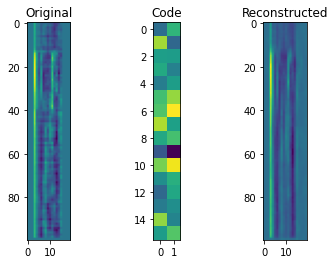

1/1 [==============================] - 0s 20ms/step


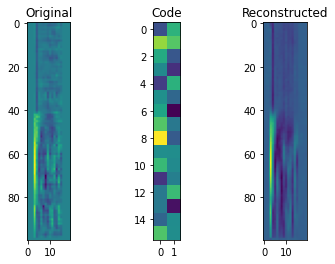

In [30]:
for i in range(2):
    idx = random.randint(0, len(X_test))
    img = normalize_mfcc(Array_test[i])
    plt.figure()
    visualize(img, encoder, decoder)
    plt.show()

In [31]:
Array_train = Array_train.tolist()
train_imgs = normalize_mfcc(Array_train)
test_imgs = normalize_mfcc(Array_test)

train_codes = encoder.predict(train_imgs)  # Encode the batch of images
train_reconstructed = decoder.predict(train_codes)  # Decode the encoded batch of images

test_codes = encoder.predict(test_imgs)  # Encode the batch of images
test_reconstructed = decoder.predict(test_codes)  # Decode the encoded batch of images

141/141 [==============================] - 1s 6ms/step


In [32]:
reconstruction_mse = autoencoder_model.evaluate(test_dataset, steps=test_steps, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

Convolutional autoencoder MSE: 0.0008233674452640116


## SVM

In [33]:
X_train = train_reconstructed
X_test = test_reconstructed
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [34]:
X_train.shape

(18033, 100, 20, 1)

In [35]:
X_test.shape

(4509, 100, 20, 1)

In [36]:
Y_train.shape

(18033, 9)

In [37]:
Y_test.shape

(4509, 9)

# SVM on reconstructed mfcc images

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time  # Import the time module

# Record the start time
start_time = time.time()

# Your existing code
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
Y_train_flattened = np.argmax(Y_train, axis=1)
Y_test_flattened = np.argmax(Y_test, axis=1)

print("Fitting model:")
svm_model = SVC(kernel='linear', verbose=True)
svm_model.fit(X_train_reshaped, Y_train_flattened)
predictions = svm_model.predict(X_test_reshaped)
accuracy = accuracy_score(Y_test_flattened, predictions)
print("Accuracy:", accuracy)

# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Fitting model:
[LibSVM]Accuracy: 0.7143490796185407
Execution time: 303.57360100746155 seconds


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       326
           1       0.53      0.53      0.53       414
           2       0.69      0.73      0.71       432
           3       0.77      0.81      0.79       771
           4       0.71      0.83      0.77       756
           5       0.72      0.64      0.68       400
           6       0.73      0.57      0.64       327
           7       0.76      0.74      0.75       759
           8       0.72      0.67      0.70       324

    accuracy                           0.71      4509
   macro avg       0.71      0.68      0.69      4509
weighted avg       0.71      0.71      0.71      4509



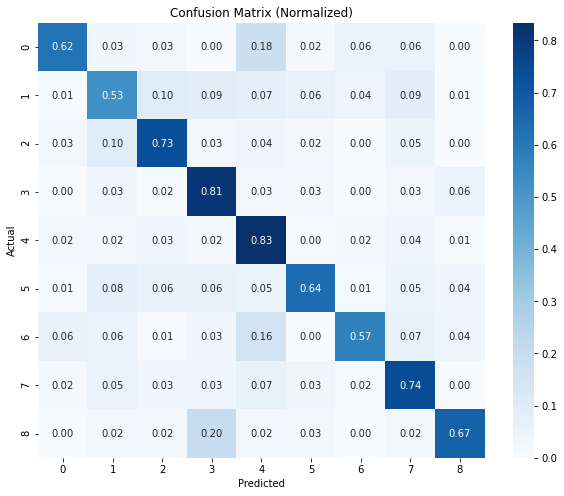

Memory Usage: 194.31 MB


In [42]:
# Classification Report
class_report = classification_report(Y_test_flattened, predictions)
print("Classification Report:")
print(class_report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test_flattened, predictions)

# Convert confusion matrix to percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()


# Get memory usage
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 ** 2)  # in megabytes
print("Memory Usage: {:.2f} MB".format(memory_usage))


In [35]:
# Save the trained model using joblib
joblib.dump(svm_model, 'models/autoencoder/autoencoder_svm_model.pkl')

# Save the label encoder
joblib.dump(one_hot_encoder, 'models/autoencoder/label_encoder_autoencoder_svm.pkl')

['models/autoencoder/label_encoder_autoencoder_svm.pkl']

## SVM on images

In [ ]:
# X_train = Array_train
# X_test = Array_test
# Y_train = np.array(Y_train)
# Y_test = np.array(Y_test)

In [ ]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# import numpy as np
# from tqdm import tqdm  # Import tqdm

# # Reshape the input data
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# # Flatten Y_train and Y_test if needed
# Y_train_flattened = np.argmax(Y_train, axis=1)
# Y_test_flattened = np.argmax(Y_test, axis=1)

# print("Fitting model:")
# # Initialize and train the SVM model with tqdm progress bar
# svm_model = SVC(kernel='linear', verbose=True)  # You can choose different kernels like 'rbf', 'poly', etc.

# # Train on the current batch
# svm_model.fit(X_train_reshaped, Y_train_flattened)

# # Make predictions
# predictions = svm_model.predict(X_test_reshaped)

# # Calculate accuracy
# accuracy = accuracy_score(Y_test_flattened, predictions)
# print("Accuracy:", accuracy)


In [ ]:
# # Classification Report
# class_report = classification_report(Y_test_flattened, predictions)
# print("Classification Report:")
# print(class_report)

# # Calculate confusion matrix
# conf_matrix = confusion_matrix(Y_test_flattened, predictions)

# # Plot confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=range(conf_matrix.shape[1]), 
#             yticklabels=range(conf_matrix.shape[0]))
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


# # Get memory usage
# process = psutil.Process(os.getpid())
# memory_usage = process.memory_info().rss / (1024 ** 2)  # in megabytes
# print("Memory Usage: {:.2f} MB".format(memory_usage))
